# <center>Abnormality Detection in Musculoskeletal Radiographs using Deep Learning</center>
## <center>Authors: Divya Shankar | Sabrina Sok | Snigdha Jain</center>

<img src="Bone.jpg" style="height:350px" style="width:350px">

## Introduction

Musculoskeletal conditions affect more than 1.7 billion people worldwide, and are the most common cause of severe, long-term pain and disability, with 30 million emergency department visits annually and increasing. Bone X-Rays are used to detect these musculoskeletal conditions. <b>MURA</b> (<b>mu</b>sculoskeletal <b>ra</b>diographs) is a large dataset of bone X-rays.

Dataset is created by Stanford.
Consists of 14,863 studies from 12,173 patients, with a total of 40,561 multi-view radiographic images.
Body parts covered: elbow, finger, forearm, hand, humerus, shoulder, and wrist.
Study manually labeled as normal or abnormal


The original image dimensions are 512 x 512

## Problem Statement:

Classify X-Rays from MURA dataset into two conditions:
1. Normal
2. Abnormal

## Project Approach:

1. <b>Data Preparation</b>:
    * Image Preprocessing is done using ImageDataGenerator & flow_from_directory to generate a batch of augmented/normalized data

2. <b>Model</b>:
    * We use a pretrained convolutional network - MobileNet as a convolutional base.
    * To this convolutional base, we added a global average pooling 2D layer to reduce data significantly and prepare the model for the final classification layer.
    * The final layer uses a sigmoid activation function and performs a binary classification to give one output class - abnormal/normal.
    * The hyper parameters tuned in our model to minimize the loss function (Binary Cross Entropy) are as follows:
        * Optimizer: Adam Optimizer
        * Learning Rate: 1e-4
        
        

## Initial Environment Setup

1. Pandas
2. Numpy
3. Matplotlib
4. Keras: pip install keras
5. Tensorflow: pip install tensorflow

## Import Required Packages

In [205]:
import warnings
warnings.filterwarnings('ignore')
import os, shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#For image preprocessing, building, training and evaluation of Neural Network 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Dense, GlobalAveragePooling2D, MaxPooling2D
from keras import models
from keras.models import Model, Sequential
from keras import optimizers
from keras.applications import MobileNetV2
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
import random
import imageio
import PIL
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Convolution2D, BatchNormalization, concatenate, UpSampling2D

In [2]:
keras.__version__

'2.3.1'

In [5]:
# --------Print all the outputs in a cell--------
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
os.getcwd()

'/tmp/ssok'

## MURA Dataset Description

1. MURA is a dataset of musculoskeletal radiographs consisting of 14,863 studies from 12,173 patients, with a total of 40,561 multi-view radiographic images. 
2. Each belongs to one of seven standard upper extremity radiographic study types: elbow, finger, forearm, hand, humerus, shoulder, and wrist. 
3. Each study was manually labeled as normal or abnormal by board-certified radiologists from the Stanford Hospital at the time of clinical radiographic interpretation in the diagnostic radiology environment between 2001 and 2012.
4. MURA is one of the largest public radiographic image datasets. 
5. <b>Sample of pictures from MURA Dataset:<b>

<img src="MURA_Image.jpeg" style="height:450px" style="width:450px">

## Import & Process Data

In [ ]:
import pandas as pd

In [78]:
df = pd.read_csv('/Users/sabrinasok/Desktop/MURA-v1.1/train_labeled_studies.csv')

In [87]:
def create_lab(x):
    label = None
    if x > 0:
        label = 'Normal'
    else:
        label = 'Abnormal'
    return label

In [88]:
df['label'] = df['1'].apply(create_lab)

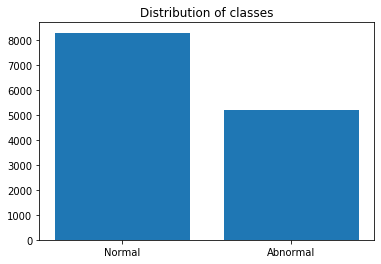

In [101]:
from matplotlib import pyplot as plt

plt.bar(df['label'].unique(),df['label'].value_counts().tolist())
plt.title('Distribution of classes')
plt.show()


In [35]:
rootDir = '/Users/sabrinasok/Desktop/'
rawDataDir = rootDir+'MURA-v1.1/'
rawTrainDir = rawDataDir+'train/'
rawValDir = rawDataDir+'valid/'
label_dict = {'positive':1, 'negative':0}
trainP = np.array([rootDir+x for x in np.loadtxt(
    rawDataDir+'train_image_paths.csv', dtype=str)])
trainLab = np.array([label_dict[x.split('/')[-2].split('_')[-1]] for x in trainP])
valP = np.array([rootDir+x for x in np.loadtxt(
    rawDataDir+'valid_image_paths.csv', dtype=str)])
valLab = np.array([label_dict[x.split('/')[-2].split('_')[-1]] for x in valP])
fd = './Figures/'
checkpoint_dir = rootDir+'Weights/'
processedDataDir = rootDir+'Processed_MURA/'
processedTrainDir = processedDataDir+'Train/'
processedValDir = processedDataDir+'Valid/'

In [7]:
def make_data(files, destination, labels=['positive', 'negative']):
    new_names = []
    path_exist = os.path.isdir(destination)
    os.makedirs(destination, exist_ok = True)
    if path_exist:
        print('Not copying new files over as the directories already exist!')
    for l in labels:
        os.makedirs(os.path.join(destination, l), exist_ok = True)
    for i, f in enumerate(files):
        label = f.split('/')[-2].split('_')[-1]
        new_path = os.path.join(destination, label) + '/' + str(i) + '.png'
        new_names.append(new_path)
        if path_exist is False:
            shutil.copyfile(f, new_path)
    print('Finished!')
    return new_names

In [8]:
train_path = make_data(trainP, destination=processedTrainDir)

Not copying new files over as the directories already exist!
Finished!


In [9]:
val_path = make_data(valP, destination=processedValDir)

Not copying new files over as the directories already exist!
Finished!


In [10]:
np.shape(train_path)

(36808,)

In [11]:
np.shape(val_path)

(3197,)

## Visualize Data

In [136]:
def count_sample_representation(trainP, valP, trainLab, valLab, fn=''):
    train_n = len(trainP)
    train_positive = sum(trainLab)
    train_positive_p = train_positive / train_n
    train_negative = train_n - train_positive
    train_negative_p = train_negative / train_n

    val_n = len(valP)
    val_positive = sum(valLab)
    val_positive_p = val_positive / val_n
    val_negative = val_n - val_positive
    val_negative_p = val_negative / val_n

    fig, ax = plt.subplots(figsize=(4, 3), dpi=85)
    ax.bar([0, 1, 2, 3],
            [train_negative, train_positive, val_negative, val_positive],
            width=0.85, zorder=10, color=['C0', 'C0', 'C1', 'C1'],
            alpha=0.8, edgecolor='k')
    ax.set_xticklabels(['', 'Negative', 'Positive', 'Negative', 'Positive'],
            fontsize=10)
    ax.set_ylabel('Number of samples')
    ax.text(0.25, -0.175, 'Train', ha='center', transform=ax.transAxes)
    ax.text(0.75, -0.175, 'Validation', ha='center', transform=ax.transAxes)
    ax.text(0, train_negative/1.2, str(round(train_negative_p, 2)*100)+'%',
            ha='center', zorder=10, weight='bold', fontsize=12)
    ax.text(1, train_positive/1.2, str(round(train_positive_p, 2)*100)+'%',
            ha='center', zorder=10, weight='bold', fontsize=12)
    ax.text(2, val_negative*1.5, str(round(val_negative_p, 2)*100)+'%',
            ha='center', zorder=10, weight='bold', fontsize=12)
    ax.text(3, val_positive*1.5, str(round(val_positive_p, 2)*100)+'%',
            ha='center', zorder=10, weight='bold', fontsize=12)
    if fn != '':
        fig.savefig(fd+fn, bbox_inches='tight')

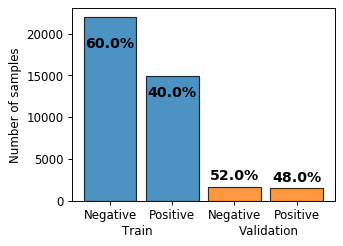

In [14]:
count_sample_representation(trainP, valP, trainLab, valLab)

In [15]:
def count_key(ls, key=-4, sep='/'):
    return([x.split(sep)[key] for x in ls])

In [16]:
def organ_type_label_frequency(trainP, valP, trainLab, valLab, fn=''):
    train_n = len(trainP)
    val_n = len(valP)
    train_org = np.array(count_key(trainP))
    val_org = np.array(count_key(valP))
    df_train = pd.DataFrame(trainLab, columns=['label'])
    df_train['Organ'] = train_org
    df_train = df_train.groupby(['Organ']).mean()*100

    df_val = pd.DataFrame(valLab, columns=['label'])
    df_val['Organ'] = val_org
    df_val = df_val.groupby(['Organ']).mean()*100

    fig, axs = plt.subplots(figsize=(6, 4), nrows=2, dpi=90)
    fig.subplots_adjust(hspace=0.4)
    df_train.plot(kind='bar', ax=axs[0], legend=False, rot=0, zorder=10,
            ec='k', title='Train', color='C0')
    axs[0].set_xlabel('')
    df_val.plot(kind='bar', ax=axs[1], legend=False, rot=0, zorder=10,
            ec='k', title='Validation', color='C1')
    for ax in axs:
        ax.tick_params(labelsize=6)
        ax.set_ylabel('% Positive', fontsize=10)
    if fn != '':
        fig.savefig(fd+fn, bbox_inches='tight')

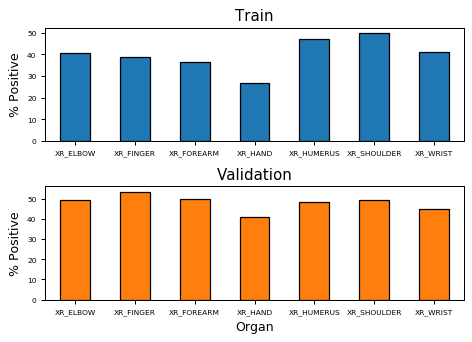

In [17]:
organ_type_label_frequency(trainP, valP, trainLab, valLab)

## MobileNet Transfer Learning

In [17]:
conv_base = MobileNetV2(weights = 'imagenet',
                       include_top = False,
                       input_shape = (224, 224, 3))

### Freeze Convolutional Base

In [18]:
conv_base.trainable = False

### Extract Features

In [52]:
batch_size = 8
train_datagen = ImageDataGenerator(rescale = 1./255,
                            rotation_range = 45,
                            zoom_range = 0.2,
                            horizontal_flip = True,
                            vertical_flip = True)

valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(processedTrainDir,
                                                   target_size = (224,224),
                                                   batch_size = batch_size,
                                                   class_mode = 'binary',
                                                   shuffle = True)

val_generator = valid_datagen.flow_from_directory(processedValDir,
                                    target_size = (224,224),
                                    batch_size = batch_size,
                                    class_mode = 'binary',
                                    shuffle = True)

n_train_samples = train_generator.samples
n_val_samples = val_generator.samples

Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.


### Define & Train Densely Connected Classifier

In [20]:
def make_callbacks(checkpoint_dir, metric='accuracy'):
    unique_filename = uuid.uuid4().hex
    callbacks = [
        ModelCheckpoint(filepath=checkpoint_dir+"/gpu_weights_"+unique_filename+".hdf5",
                        monitor='loss', save_best_only=False, verbose=1),
        ReduceLROnPlateau(monitor=metric, factor=0.5, patience=20, verbose=1)]
    callbacks.append(CSVLogger(checkpoint_dir+"gpu_stats_per_epoch_"+unique_filename+".csv",
        append=True))
    return callbacks

In [21]:
callbacks = make_callbacks(checkpoint_dir+'mobileNet/', 'accuracy')

In [22]:
from keras import models
from keras import layers
from keras import optimizers

x = conv_base.output  # Recast classification layer
x = GlobalAveragePooling2D()(x)
# n_classes; softmax for multi-class, sigmoid for binary
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=conv_base.input, outputs=x)

model.compile(optimizer=optimizers.Adam(learning_rate = 1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_generator,steps_per_epoch= n_train_samples // batch_size,
        epochs= 15,
        validation_data=val_generator,
        validation_steps= n_val_samples // batch_size,
        workers=cpu_count(),
        callbacks=callbacks
        )

model.save(checkpoint_dir+'mobileNet/x.hdf5')

Epoch 1/15
4601/4601 [==============================] - 747s 162ms/step - loss: 0.5524 - accuracy: 0.7267 - val_loss: 0.1751 - val_accuracy: 0.7422

Epoch 00001: saving model to ./Weights/mobileNet//gpu_weights_19e9e4ba27ab465fb9eee078e8e37c6e.hdf5
Epoch 2/15
4601/4601 [==============================] - 731s 159ms/step - loss: 0.5009 - accuracy: 0.7667 - val_loss: 0.3204 - val_accuracy: 0.7532

Epoch 00002: saving model to ./Weights/mobileNet//gpu_weights_19e9e4ba27ab465fb9eee078e8e37c6e.hdf5
Epoch 3/15
4601/4601 [==============================] - 731s 159ms/step - loss: 0.4826 - accuracy: 0.7794 - val_loss: 1.1573 - val_accuracy: 0.7579

Epoch 00003: saving model to ./Weights/mobileNet//gpu_weights_19e9e4ba27ab465fb9eee078e8e37c6e.hdf5
Epoch 4/15
4601/4601 [==============================] - 730s 159ms/step - loss: 0.4708 - accuracy: 0.7899 - val_loss: 0.2827 - val_accuracy: 0.7695

Epoch 00004: saving model to ./Weights/mobileNet//gpu_weights_19e9e4ba27ab465fb9eee078e8e37c6e.hdf5
Epoc

## Plot results of model training

In [217]:
df = pd.read_csv('/Users/sabrinasok/Desktop/Weights/mobileNet/gpu_stats_per_epoch_19e9e4ba27ab465fb9eee078e8e37c6e.csv')

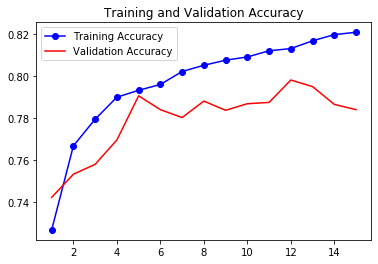

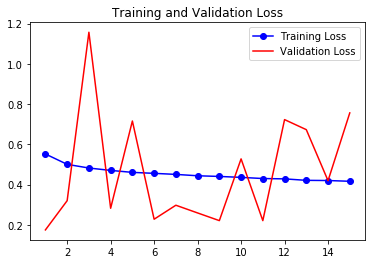

In [218]:
acc = df['accuracy']
val_acc = df['val_accuracy']
loss = df['loss']
val_loss = df['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

### Evaluate Model on Test Data

In [24]:
score, acc = model.evaluate_generator(val_generator, n_val_samples / batch_size)
print("loss :{:0.4f} \t Accuracy:{:0.4f}".format(score, acc))

loss :1.0213 	 Accuracy:0.7957


## Simple Model

In [207]:
def TrainGen():
    datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest')
    return datagen

def ValidationGen():
    datagen = ImageDataGenerator(rescale=1./255)
    return datagen

In [194]:
def simple_mobile_net():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(300, 300, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(32, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
    return model

In [209]:
batch_size = 16
num_epochs = 10

In [210]:
TrainGen = TrainGen()
train_generator = TrainGen.flow_from_directory(
        processedTrainDir,  # this is the target directory
        target_size=(300, 300),  # all images will be resized to this size
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels 
ValidationGen = ValidationGen()
val_generator = ValidationGen.flow_from_directory(
        processedValDir,  # this is the target directory
        target_size=(300, 300),  # all images will be resized to this size
        batch_size=batch_size,
        class_mode='binary')  # since we use binary_crossentropy loss, we need binary labels 

Found 36808 images belonging to 2 classes.
Found 3197 images belonging to 2 classes.


In [ ]:
base_model = simple_mobile_net()

In [ ]:
history = base_model.fit_generator(
            train_generator,
            steps_per_epoch=2000 // batch_size,
            epochs=num_epochs,
            validation_data=val_generator,
            validation_steps=800 // batch_size,
            workers=cpu_count(),
            max_queue_size=10,
            callbacks=callbacks)

In [226]:
df = pd.read_csv('/Users/sabrinasok/Desktop/Weights/simple_model1/gpu_stats_per_epoch_d30456ca68d845a88fc6103051c6b007.csv')

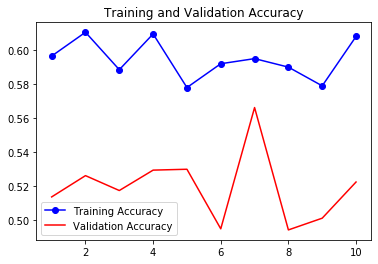

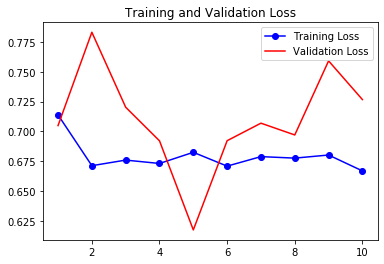

In [227]:
acc = df['accuracy']
val_acc = df['val_accuracy']
loss = df['loss']
val_loss = df['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Complex Model

In [211]:
batch_size = 16
num_epochs = 200
shape = 300

In [193]:
def complex_model(input_shape):
    inputs = Input(input_shape)
    conv1 = Convolution2D(32, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(inputs)
    bn1 = BatchNormalization()(conv1)
    conv1 = Convolution2D(32, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn1)
    bn1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    # conv2 = Convolution2D(64, 3, activation='relu', border_mode='same', kernel_initializer='he_normal')(inputs)
    conv2 = Convolution2D(64, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(pool1)
    bn2 = BatchNormalization()(conv2)
    conv2 = Convolution2D(64, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn2)
    bn2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Convolution2D(128, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(pool2)
    bn3 = BatchNormalization()(conv3)
    conv3 = Convolution2D(128, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn3)
    bn3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Convolution2D(256, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(pool3)
    bn4 = BatchNormalization()(conv4)
    conv4 = Convolution2D(256, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn4)
    bn4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Convolution2D(512, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(pool4)
    bn5 = BatchNormalization()(conv5)
    conv5 = Convolution2D(512, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn5)
    bn5 = BatchNormalization()(conv5)
    pool5 = MaxPooling2D(pool_size=(2, 2))(bn5)

    conv5_2 = Convolution2D(512, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(pool5)
    bn5_2 = BatchNormalization()(conv5_2)
    conv5_2 = Convolution2D(512, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn5_2)
    bn5_2 = BatchNormalization()(conv5_2)

    conv6_2 = Convolution2D(512, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn5_2)
    bn6_2 = BatchNormalization()(conv6_2)

    conv6 = Convolution2D(256, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn6_2)
    bn6 = BatchNormalization()(conv6)

    conv7 = Convolution2D(128, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn6)
    bn7 = BatchNormalization()(conv7)

    conv8 = Convolution2D(64, 3, activation='relu', border_mode='same', kernel_initializer='he_normal')(bn7)
    bn8 = BatchNormalization()(conv8)

    conv9 = Convolution2D(32, 3, activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn8)
    bn9 = BatchNormalization()(conv9)

    conv10 = Convolution2D(16, (3, 3), activation='relu', border_mode='same',
            kernel_initializer='he_normal')(bn9)
    bn10 = BatchNormalization()(conv10)

    x = GlobalAveragePooling2D()(bn10)
    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
    x = BatchNormalization()(x)
    x = Dense(1024,activation='relu', kernel_initializer='he_normal')(x) #dense layer 2
    x = BatchNormalization()(x)
    x = Dense(512,activation='relu', kernel_initializer='he_normal')(x) #dense layer 3
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    preds = Dense(1, activation='sigmoid', kernel_initializer='he_normal')(x) #final layer with softmax activation
    model = Model(input=inputs, output=preds)
    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
base_model.fit_generator(
        train_generator,
        steps_per_epoch=2000 // batch_size,
        epochs=num_epochs,
        validation_data=val_generator,
        validation_steps=800 // batch_size,
        workers=cpu_count(),
        max_queue_size=10,
        callbacks=callbacks)

In [230]:
df = pd.read_csv('/Users/sabrinasok/Desktop/Weights/complex_model/gpu_stats_per_epoch_ee69b30821c6470a996a5c3d01e5e192.csv')

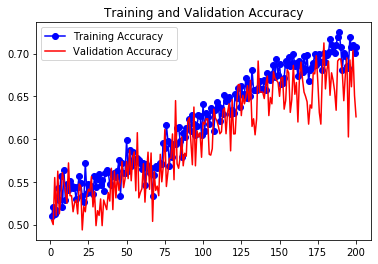

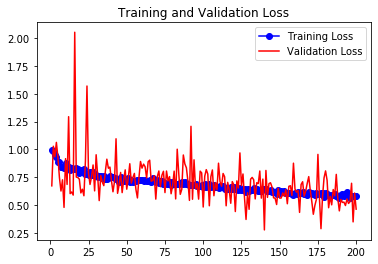

In [231]:
acc = df['accuracy']
val_acc = df['val_accuracy']
loss = df['loss']
val_loss = df['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b-o', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

## Predicting Data

In [212]:
def mobileNet():
    model = keras.applications.mobilenet_v2.MobileNetV2(weights = 'imagenet',
                       include_top = False,input_shape = (224, 224, 3))
    x = model.output
    x = GlobalAveragePooling2D()(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=preds)
    model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [213]:
base_model = mobileNet()

In [167]:
weights = checkpoint_dir + 'mobileNet/gpu_weights_19e9e4ba27ab465fb9eee078e8e37c6e.hdf5'
x = base_model.load_weights(weights)

In [191]:
test_img = imageio.imread(processedValDir+'negative/2726.png')
test_img = np.array(PIL.Image.fromarray(test_img).resize(size=(224,224)))
test_img = test_img.reshape(1, test_img.shape[0], test_img.shape[1], -1)
test_img = np.concatenate([test_img], axis=3)

base_model.predict(test_img)

array([[0.674605]], dtype=float32)

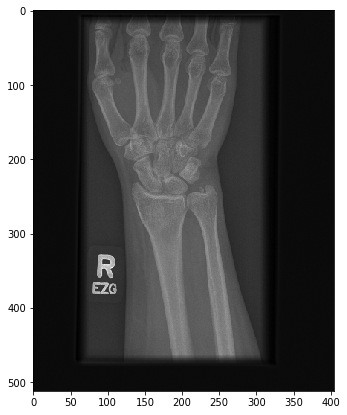

In [76]:
img = imageio.imread(processedValDir+'negative/534.png')
plt.figure(figsize=(7, 7))
plt.imshow(img, cmap='binary_r')
plt.grid(False);

## Comparison of Models

<img src="x.png" style="height:350px" style="width:350px">

The MobileNet version 2 overall works much better than the two other models that we implemented. We speculate that the spikes and inconsistencies in the validation loss for all the models are due to small batch sizes.

## Future Work:

- Improve model accuracy
- Extensive Hyperparameter tuning
- Implement regularization to avoid overfitting
- Deployment of solution on cloud platforms
- Development of a front-end application

## References:

1. MURA Dataset: https://stanfordmlgroup.github.io/competitions/mura/
2. Keras Documentation: https://keras.io